In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from natsort import natsorted

%matplotlib inline

# use type 1 fonts only (required for AAAI publication)
plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['text.usetex'] = True

# files to evaluate
af = pd.read_csv('../data/mar-23-2019-results.csv')

In [2]:
af.head()

,Unnamed: 0,Unnamed: 0.1,AgentID,Plan,Seconds,Makespan,Cost,Expansions,MessagesIn,MessagesOut,HeuristicValue,AgentCount,Domain,Problem,Config,t,Search
0,0,0,1,3-351876,78.153007,-1,157,20111.0,3,3,4,4,productionsite,4-5-6-6,dmtg-ff1-t340,340,dmtg
1,1,1,2,1-83,0.650896,-1,50,550.0,14,0,4,4,productionsite,4-7-1-1,dmtg-ff1-t90,90,dmtg
2,2,2,2,2-310,0.650938,-1,55,550.0,14,0,4,4,productionsite,4-7-1-1,dmtg-ff1-t90,90,dmtg
3,3,3,2,0-28,0.650958,-1,44,550.0,14,0,4,4,productionsite,4-7-1-1,dmtg-ff1-t90,90,dmtg
4,4,4,2,1-130,0.650971,-1,44,550.0,14,0,4,4,productionsite,4-7-1-1,dmtg-ff1-t90,90,dmtg


In [2]:
cov = af.groupby(
    by=['Config', 'Domain', 'Problem'])['Plan'].first().groupby(
    by=['Config', 'Domain']).count().unstack('Config').fillna(0)
cov = cov.reindex(columns=natsorted(cov.columns))
cov[['dmtb-ff1-t{}'.format(x) for x in [1] + list(range(10,410,10))]].sum().sort_values()
cov.style.highlight_max(axis=1, color='yellow')

Config,dmtb-ff1-t1,dmtb-ff1-t10,dmtb-ff1-t20,dmtb-ff1-t30,dmtb-ff1-t40,dmtb-ff1-t50,dmtb-ff1-t60,dmtb-ff1-t70,dmtb-ff1-t80,dmtb-ff1-t90,dmtb-ff1-t100,dmtb-ff1-t110,dmtb-ff1-t120,dmtb-ff1-t130,dmtb-ff1-t140,dmtb-ff1-t150,dmtb-ff1-t160,dmtb-ff1-t170,dmtb-ff1-t180,dmtb-ff1-t190,dmtb-ff1-t200,dmtb-ff1-t210,dmtb-ff1-t220,dmtb-ff1-t230,dmtb-ff1-t240,dmtb-ff1-t250,dmtb-ff1-t260,dmtb-ff1-t270,dmtb-ff1-t280,dmtb-ff1-t290,dmtb-ff1-t300,dmtb-ff1-t310,dmtb-ff1-t320,dmtb-ff1-t330,dmtb-ff1-t340,dmtb-ff1-t350,dmtb-ff1-t360,dmtb-ff1-t370,dmtb-ff1-t380,dmtb-ff1-t390,dmtb-ff1-t400,dmtg-ff1-t1,dmtg-ff1-t10,dmtg-ff1-t20,dmtg-ff1-t30,dmtg-ff1-t40,dmtg-ff1-t50,dmtg-ff1-t60,dmtg-ff1-t70,dmtg-ff1-t80,dmtg-ff1-t90,dmtg-ff1-t100,dmtg-ff1-t110,dmtg-ff1-t120,dmtg-ff1-t130,dmtg-ff1-t140,dmtg-ff1-t150,dmtg-ff1-t160,dmtg-ff1-t170,dmtg-ff1-t180,dmtg-ff1-t190,dmtg-ff1-t200,dmtg-ff1-t210,dmtg-ff1-t220,dmtg-ff1-t230,dmtg-ff1-t240,dmtg-ff1-t250,dmtg-ff1-t260,dmtg-ff1-t270,dmtg-ff1-t280,dmtg-ff1-t290,dmtg-ff1-t300,dmtg-ff1-t310,dmtg-ff1-t320,dmtg-ff1-t330,dmtg-ff1-t340,dmtg-ff1-t350,dmtg-ff1-t360,dmtg-ff1-t370,dmtg-ff1-t380,dmtg-ff1-t390,dmtg-ff1-t400,mafs-ff1-t1,mafs-ff1-t10,mafs-ff1-t20,mafs-ff1-t30,mafs-ff1-t40,mafs-ff1-t50,mafs-ff1-t60,mafs-ff1-t70,mafs-ff1-t80,mafs-ff1-t90,mafs-ff1-t100,mafs-ff1-t110,mafs-ff1-t120,mafs-ff1-t130,mafs-ff1-t140,mafs-ff1-t150,mafs-ff1-t160,mafs-ff1-t170,mafs-ff1-t180,mafs-ff1-t190,mafs-ff1-t200,mafs-ff1-t210,mafs-ff1-t220,mafs-ff1-t230,mafs-ff1-t240,mafs-ff1-t250,mafs-ff1-t260,mafs-ff1-t270,mafs-ff1-t280,mafs-ff1-t290,mafs-ff1-t300,mafs-ff1-t310,mafs-ff1-t320,mafs-ff1-t330,mafs-ff1-t340,mafs-ff1-t350,mafs-ff1-t360,mafs-ff1-t370,mafs-ff1-t380,mafs-ff1-t390,mafs-ff1-t400
Domain,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
blocksworld,15,6,3,2,3,4,5,1,0,3,4,2,2,3,4,2,3,3,0,6,2,2,1,2,3,1,2,4,4,4,2,3,0,1,1,1,1,3,2,2,3,0,6,10,12,12,15,16,14,14,17,16,18,19,16,18,15,18,19,19,18,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,0,8,13,11,12,17,18,16,15,16,18,16,17,18,16,18,19,18,17,19,18,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19
depot,1,2,2,2,2,3,3,3,2,2,3,3,2,3,2,3,2,2,2,2,3,2,2,2,3,3,2,2,2,2,3,2,2,2,2,2,2,3,2,2,3,4,5,4,4,4,5,6,4,4,4,4,4,3,4,5,3,4,3,3,3,3,4,4,5,4,3,4,4,4,4,4,5,3,4,5,4,4,3,5,4,4,3,2,2,2,4,4,3,3,3,3,3,3,2,3,4,2,3,2,2,2,1,5,2,3,4,3,4,3,2,3,3,4,2,2,2,3,2,1,3,2,3
driverlog,15,15,15,16,15,15,17,16,17,17,17,18,17,17,17,17,19,17,18,18,18,18,18,17,18,18,17,18,19,18,17,18,17,17,18,18,17,18,17,18,18,17,20,20,20,20,20,20,20,19,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,18,20,19,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20
elevators08,4,4,5,6,6,6,6,5,7,6,6,5,5,6,5,5,5,6,6,6,4,6,6,5,7,6,3,5,6,6,6,4,5,5,5,5,6,6,5,7,5,10,10,10,9,11,10,7,10,9,9,11,8,9,10,11,10,9,10,8,12,11,11,9,11,11,9,11,8,12,11,7,10,11,8,8,12,11,10,9,11,11,13,10,12,12,12,12,14,13,14,12,13,12,13,15,11,14,14,14,12,12,12,15,13,12,14,13,11,13,12,13,13,12,11,13,16,12,16,14,14,12,13
logistics00,3,3,5,4,7,6,6,7,5,5,8,6,6,6,7,6,7,5,6,6,7,7,5,7,7,7,6,6,7,7,7,5,7,7,5,5,6,6,6,6,7,16,16,19,19,19,19,19,18,19,17,19,18,20,20,19,19,18,18,17,19,19,19,17,15,18,19,19,19,19,16,16,16,17,19,18,18,19,17,18,16,19,20,20,20,20,18,19,20,19,20,19,20,18,18,18,20,19,19,20,19,18,17,18,19,20,20,19,18,19,20,19,18,20,19,20,18,18,18,20,19,18,20
productionsite,20,21,25,26,24,23,26,25,24,25,26,25,25,25,25,23,26,23,26,25,25,26,25,26,24,24,25,25,24,24,25,25,25,26,26,25,26,24,25,23,25,29,30,29,30,24,24,23,23,27,26,27,28,23,23,29,24,24,25,25,27,26,25,28,25,24,23,24,25,27,26,25,25,26,24,26,24,25,24,24,24,27,35,24,20,17,20,21,17,18,19,20,18,18,19,18,19,17,18,22,20,18,19,19,18,19,18,23,21,20,21,21,21,18,20,17,19,21,19,21,20,20,18
rovers,7,11,10,12,15,15,14,17,16,15,17,18,18,17,18,18,18,17,18,17,18,18,16,17,16,17,17,18,17,18,18,18,16,17,17,18,18,18,18,17,18,13,19,20,20,20,20,20,20,20,2

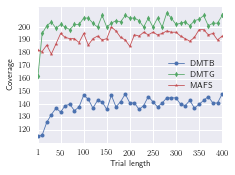

In [49]:
plt.rc('text', usetex=True)
plt.rcParams["figure.figsize"] = [3.3, 2.5] # width, height in inch
#plt.rc('font', family='serif')

cov = af.groupby(
    by=['Domain', 'Problem', 'Config']).first().groupby(
    by=['t', 'Search']).Plan.count().unstack('Search')
#cov.style.highlight_max(axis=1)

cov.plot(style=['o-', 'd-', '*-'], linewidth=.8, markersize=4)

plt.xlabel('Trial length', fontsize=8)
plt.ylabel('Coverage', fontsize=8)
plt.yticks(range(120,210,10), fontsize=8)
plt.xticks([1] + list(range(50,450,50)), fontsize=8)
plt.legend(('DMTB', 'DMTG', 'MAFS'), loc='best', fontsize=8)
plt.savefig('../data/line-coverage.pdf', bbox_inches='tight', dpi=300)

/home/tim/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


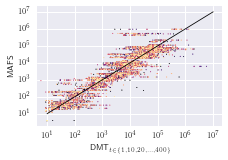

In [56]:
from matplotlib import cm
plt.rcParams["figure.figsize"] = [3.3, 2.2] # width, height in inch

cmp = af.groupby(
    by=['Domain', 'Problem', 'Config']).agg({
        'Expansions': 'sum',
        'MessagesOut': 'sum',
        'Cost': 'min',
        'Seconds': 'min',
        't': 'first',
        'Search': 'first',
    }).unstack('Config')

configs=['dmtg-ff1-t{}'.format(i) for i in [1] + list(range(10,410,10))]
versus='mafs-ff1-t1'
colors = cm.get_cmap('magma')
get_color = lambda x: colors(x/400.0)

f, ax = plt.subplots()
for c in configs:
    sctrs = ax.scatter(
        x=cmp.MessagesOut[c],#.fillna(1e7), 
        y=cmp.MessagesOut[versus],#.fillna(1e7), 
        c=get_color(cmp.t[c]),
        s=.5,
    )

ax.set_xscale('log')
ax.set_yscale('log')


ax.set_xticks([1e1,1e2,1e3,1e4,1e5,1e6,1e7])
ax.set_yticks([1e1,1e2,1e3,1e4,1e5,1e6,1e7])

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

ax.set_xlabel('DMT$_{t\in \{1,10,20,\dots,400\}}$', fontsize=8)
ax.set_ylabel('MAFS', fontsize=8)
ax.plot([1e1,1e7], [1e1,1e7], c='black', linewidth=.8)

#plt.tight_layout()
#plt.show()
f.savefig('../data/scatter-messages.pdf', bbox_inches='tight', pad_inches=0)
f.savefig('../data/scatter-messages.png', bbox_inches='tight', pad_inches=0, dpi=300)

In [5]:
from scipy import stats

configs = [
    'mafs-ff1-t1', 
    'dmtg-ff1-t1', 
    'dmtb-ff1-t1'
]
mut = af.groupby(
    by=['Domain', 'Problem', 'Config']).agg({
        'Expansions': 'sum',
        'MessagesOut': 'sum',
        'Cost': 'min',
        'Seconds': 'max',
        't': 'first',
        'Search': 'first',
    }).unstack('Config')
mut = mut[~(mut.Expansions[configs].isnull().any(axis=1))]
mut = mut.groupby(by='Domain').mean().round(1).Expansions
print(stats.gmean(mut['dmtg-ff1-t1'] / mut['mafs-ff1-t1']), 
      stats.gmean(mut['dmtb-ff1-t1'] / mut['mafs-ff1-t1']))

0.649691273617 5.69257338053


In [6]:
configs = [
    'mafs-ff1-t1', 
    #'dmtg-ff1-t1', 
    #'dmtb-ff1-t1',
    #'mafs-ff1-t100',
    #'dmtg-ff1-t100',
    #'dmtb-ff1-t100',
    'dmtg-ff1-t280',
    'mafs-ff1-t160',
    #'dmtb-ff1-t400',
]

con = af[af.Domain != 'productionsite'].groupby(
    by=['Domain', 'Problem', 'Config']).agg({
        'Expansions': 'sum',
        'MessagesOut': 'sum',
        'Cost': 'min',
        'Seconds': 'max',
        't': 'first',
        'Search': 'first',
    }).unstack('Config')
con = con[~(con.Seconds[configs].isnull().all(axis=1))]
(con.Seconds[configs] < 600).any(axis = 1).value_counts()

True     192
False      1
dtype: int64

In [47]:
#af[(af.Domain == 'productionsite') & (af.Config == 'mafs-ff1-t1')].groupby(by=['Problem', 'AgentID']).max().unstack('AgentID')

In [46]:
cov = af.groupby(
    by=['Config', 'Domain', 'Problem'])['Plan'].first().groupby(
    by=['Config', 'Domain']).count().unstack('Config').fillna(0)
cov = cov.reindex(columns=natsorted(cov.columns))
#cov.loc['productionsite']

In [48]:
cmp = af.groupby(
    by=['Domain', 'Problem', 'Config']).agg({
        'Expansions': 'sum',
        'MessagesOut': 'sum',
        'Cost': 'min',
        'Seconds': 'min',
        't': 'first',
        'Search': 'first',
    }).unstack('Config')
cmp.head()
#g = sns.FacetGrid(tips, row="smoker", col="time", margin_titles=True)

Expansions                             \
Config                      dmtb-ff1-t1 dmtb-ff1-t10 dmtb-ff1-t100   
Domain      Problem                                                  
blocksworld probBLOCKS-10-0    345809.0          NaN           NaN   
            probBLOCKS-10-1         NaN     416468.0           NaN   
            probBLOCKS-10-2         NaN     268960.0           NaN   
            probBLOCKS-11-0     30405.0          NaN      701869.0   
            probBLOCKS-11-1     10974.0     331232.0      594053.0   

                                                                       \
Config                      dmtb-ff1-t110 dmtb-ff1-t120 dmtb-ff1-t130   
Domain      Problem                                                     
blocksworld probBLOCKS-10-0           NaN           NaN           NaN   
            probBLOCKS-10-1           NaN           NaN           NaN   
            probBLOCKS-10-2           NaN           NaN      418072.0   
            probBLOCKS-11-0           NaN           NaN           NaN   
            probBLOCKS-11-1           NaN           NaN           NaN   

                                                                       \
Config                      dmtb-ff1-t140 dmtb-ff1-t150 dmtb-ff1-t160   
Domain      Problem                                                     
blocksworld probBLOCKS-10-0           NaN           NaN           NaN   
            probBLOCKS-10-1           NaN      173916.0      945570.0   
            probBLOCKS-10-2           NaN           NaN      956446.0   
            probBLOCKS-11-0           NaN           NaN           NaN   
            probBLOCKS-11-1           NaN           NaN           NaN   

                                              ...             Search  \
Config                      dmtb-ff1-t170     ...      mafs-ff1-t370   
Domain      Problem                           ...                      
blocksworld probBLOCKS-10-0           NaN     ...               mafs   
            probBLOCKS-10-1           NaN     ...               mafs   
            probBLOCKS-10-2           NaN     ...               mafs   
            probBLOCKS-11-0           NaN     ...               mafs   
            probBLOCKS-11-1           NaN     ...               mafs   

                                                                      \
Config                      mafs-ff1-t380 mafs-ff1-t390 mafs-ff1-t40   
Domain      Problem                                                    
blocksworld probBLOCKS-10-0          mafs          mafs         mafs   
            probBLOCKS-10-1          mafs          mafs         mafs   
            probBLOCKS-10-2          mafs          mafs         mafs   
            probBLOCKS-11-0          mafs          mafs         mafs   
            probBLOCKS-11-1          mafs          mafs         mafs   

                                                                     \
Config                      mafs-ff1-t400 mafs-ff1-t50 mafs-ff1-t60   
Domain      Problem                                                   
blocksworld probBLOCKS-10-0          mafs         mafs         mafs   
            probBLOCKS-10-1          mafs         mafs         mafs   
            probBLOCKS-10-2          mafs         mafs         mafs   
            probBLOCKS-11-0          mafs         mafs         mafs   
            probBLOCKS-11-1          mafs         mafs         mafs   

                                                                    
Config                      mafs-ff1-t70 mafs-ff1-t80 mafs-ff1-t90  
Domain      Problem                                                 
blocksworld probBLOCKS-10-0         mafs         mafs         mafs  
            probBLOCKS-10-1         mafs         mafs         mafs  
            probBLOCKS-10-2         mafs         mafs         mafs  
            probBLOCKS-11-0         mafs         mafs         mafs  
            probBLOCKS-11-1         mafs         mafs         mafs  

[5 rows x 738 columns]